# XGBoost - Electricity Consumption 

In this notebook, XGboost Regressor is developed for time series data of electricity consumption of a state in the USA [data source](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption). 

A summary of steps followed in the model development:

1. Data cleaning and feature engineering: Data cleaning and feature engineering has been performed at [Electricity consumption - target variable analysis](https://github.com/SwatiInd/Time-Series-Analysis/blob/main/Target%20Variable%20Processing%20-%20Electricity%20Consumption.ipynb). The obtained results (e.g.: strongly correlated lags and time parameters) are included during data preparation.

2. Train/test split: Data is available from Jan 2001 to Aug 2018. The data from Jan 2017 is considered for testing model performance. 

3. Train/CV split: The training set is further divided into train and cross-validataion (CV) sets by time sereis split methods. 

4. Model optimization: Model was optimized using Grid Search method.

5. Evaluation metric: Root mean squared error

6. Prediction: A method is developed for prediction step-by-step as the future labelled value is unknown. 

Model performance was improved by adding relevant input features (e.g. lagged values, hour, month etc.). The best fitted model follows peaks and troughs of every day electricity consumption. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from TimeindexProcessing import TimeindexProcessing
from TargetVariableProcessing import TargetVariableProcessing 

In [2]:
def train_test_split(df, split_date):
    '''
    Splits one dataframe based on split date

    Parameters
    ----------
    df: dataframe
        A dataframe with datetime index
    split_date: str
        Date string to split df into train and test dataframes
    
    Returns
    -------
    Train and test dataframes for periods before and after split_date, respectively. 
    Split date is included in test df.
    '''
    train_index = df.index < split_date #Returns True for train index
    test_index = np.invert(train_index) #Returns True for test index

    train_df = df[train_index].copy()
    test_df = df[test_index].copy()
    train_df.sort_index(inplace = True)
    test_df.sort_index(inplace = True)

    return train_df, test_df

In [16]:
def split_input_output_df(df, output_parameters = []):
    '''Splits into two dataframes X and y of input featuers and output parameter

    Parameters
    ----------
    df: dataframe 
        A dataframe to split into X and y by columns 
    output_parameters: list
        A list of output parameters of independent variables
    
    Returns
    -------
    X: dataframe
        A dataframe consists of input features
    y: dataframe
        A dataframe of output parameters
    '''
    all_columns = df.columns.tolist()
    model_input_features = list(set(all_columns)-set(output_parameters))

    X = df.loc[:, model_input_features].copy()
    y = df.loc[:, output_parameters].copy()

    return X, y


In [17]:
def model_predict(X_train, y_train, test_df, 
                time_features_to_add, output_parameter,
                added_lags_features, added_lags,
                model_input_features = [],
                model = None):
    '''returns the prediction for test_df
    
    Parameters:
    -----------
    X_train: dataframe
        train input dataframe
    y_train: series
        train output values
    test_df: Dataframe
        test dataset without any dataprocessing
    time_features_to_add: list
        a list of time parameters to add
    output_parameters: str
        parameter string (e.g.: 'PJME_MW')
    added_lags_featuers: list
        a list of strings of features added by shifting data by lags
    added_lags: list
        a list of integers (e.g.: [1, 2, 4])
    model_input_features: list
        list of all features considered for data fitting
    model: 
        fitted model 

    Returns:
    -------
    test_pred: series
        series of prediction of test dataset
    '''

    test_df = test_df.copy()
    
    tvp_test = TargetVariableProcessing(test_df[output_parameter])
    time_features_df = tvp_test.create_time_features(time_features_to_add)

    test_df = pd.concat([test_df, time_features_df], axis = 1)
    #Output for test set set is unknown which will be predicted from model step-by-step
    test_df[output_parameter] = np.nan 
    test_df[added_lags_features] = np.nan

    train_intermediate = X_train.merge(y_train, left_index = True, right_index = True).copy()
    X_combine = pd.concat([train_intermediate, test_df], axis = 0)
    
    test_index = test_df.index.tolist()
    for timeindex in test_index:
        row_num = X_combine.index.get_loc(timeindex)
        # print(row_num)
        if(len(added_lags)!=0):
            for added_lag in added_lags:
                previous_row = row_num - added_lag
                # print(row_num, previous_row)
                # print(previous_row)
                column = output_parameter + str('_lag') + str(added_lag)
                X_combine.loc[timeindex, column] = X_combine.iloc[previous_row][output_parameter]
        X_combine.loc[timeindex, output_parameter] = model.predict(pd.DataFrame(X_combine.loc[timeindex, model_input_features]).T)

    test_pred = X_combine.loc[test_index, output_parameter]
    
    return test_pred


In [4]:
df = pd.read_csv('./Data/Kaggle_PJME/''PJME_hourly.csv')
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


## Section 1: Data Preprocessing

### Section 1.1: Time Index Processing
For the univariate electricity consumption data, time index is cleaned. In brief, three steps are performed:
1. Converstion of datetime column to index and sort rows by datetime
2. Dropping all rows of duplicates index except the first one
3. Adding rows of missing index in dataframe

In [5]:
from TimeindexProcessing import TimeindexProcessing 

# Create the class object
index_processing = TimeindexProcessing()

# Convert a column 'datetime' into time index
indexed_df = index_processing.convert_column_to_timeindex(df, column_name= 'Datetime')
# print(indexed_df.index[0], indexed_df.index[-1])

# Determine a list of duplicates index and build a new dataframe by keeping only first row of duplicates index
duplicates_index_list, duplicates_corrected_df = index_processing.duplicate_timeindex(indexed_df)

# Duplicates index in the original dataframe can be checked by:
indexed_df.loc[duplicates_index_list]

# Duplicates corrected dataframe for original dataframe's duplicates:
duplicates_corrected_df.loc[duplicates_index_list]
# print(duplicates_corrected_df.index[0], duplicates_corrected_df.index[-1])

# Identify missing index based on declared data frequency and add these rows into duplicates corrected dataframe
data_freq = '1H' # Define the expected data frequency
missing_index_list, rows_added_df = index_processing.missing_timeindex(duplicates_corrected_df, data_freq)
# print(rows_added_df.index[0], rows_added_df.index[-1])
# To confirm whether missing rows are added in dataframe:
# rows_added_df.loc[missing_index_list]

There are 4 duplicate index in the time series. 
There are 30 missing index in the time series


Thus obtained, dataframe has neither missing nor duplicate timeindex. Therefore, it can be used in the next steps of feature enegineering. 

### Section 2: Training dataset analysis

The data is univariate and key findings from the previous analysis [Energy Consumption - Analysis](https://github.com/SwatiInd/Time-Series-Analysis/blob/main/Target%20Variable%20Processing%20-%20Electricity%20Consumption.ipynb) are:
1. Missing value: None
2. Outliers: No unexpected value is observed
3. Seasonality and trend: There are two peaks (around 9 AM and 6 PM) and one trough around 3 AM. Consumption also depends on season of the year which can be represented by month of the year.

As there is no missing or outlier values, the dataframe obtained from Section 1 can be used here without any further processing. In case of missing or outlier output values, an appropriate action (e.g.: imputing, deleting, averaging etc) is advised. 

In [7]:
cleaned_df = rows_added_df.copy()
print('Checking column data type and null values for data modeling')
cleaned_df.info()

Checking column data type and null values for data modeling
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145392 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145362 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


### Section 2.1: Train/test split 
Here, the data before and after January 2015 are considered train and test sets, respectivly. It can also be splitted by deciding the train/test ratio. 
The training set will be splitted into train and cross-validation set later.

In [8]:
split_date = '01-01-2017'
train_df, test_df = train_test_split(cleaned_df, split_date)

**Train and test dataset visualisation**

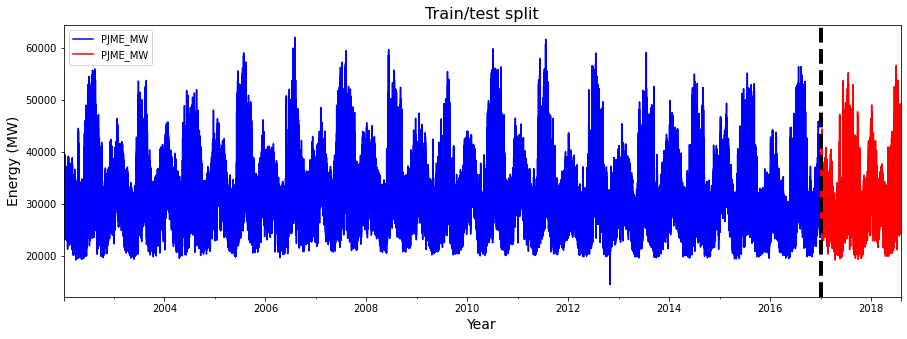

In [9]:
fig, ax = plt.subplots(figsize = (15, 5))
train_df.plot(ax = ax, label = 'Training set', color = 'blue')
test_df.plot(ax = ax, label = 'Test set', color = 'red')
ax.axvline(split_date, ls = '--', color = 'black', linewidth = 4)
ax.set_title('Train/test split', fontsize = 16);
ax.set_ylabel('Energy (MW)', fontsize = 14);
ax.set_xlabel('Year', fontsize = 14);

### Section 2.2: Feature engineering

1. Time parameters: hour of the day, month of the year, and working/weekend of the day has a strong correlation to electricity consumption. These parameters are created as input features.

2. Autocorrelation: The current value has a strong depedence on previous values with lags of 1, 2, and 24. The last one corresponds to 24-hours previous value which is the similar to hour of the day.

In the below steps, time parameters and important lags would be added for dataset. The process for creating time parameters are the same for train and test dataset. But, they are different for adding lags values as  target value are unknown for test set while known for training set.

In [10]:
output_parameter = 'PJME_MW'
tvp_train = TargetVariableProcessing(train_df[output_parameter])

#### Section 2.2.1 Time parameters

This step is the same for train and test dataset.

In [11]:
#Create time features
time_features_to_add = ['hour', 'working day', 'month']
time_features_df = tvp_train.create_time_features(time_features_to_add)
time_features_df.head()

,hour,month,working day
2002-01-01 01:00:00,1,1,0
2002-01-01 02:00:00,2,1,0
2002-01-01 03:00:00,3,1,0
2002-01-01 04:00:00,4,1,0
2002-01-01 05:00:00,5,1,0


#### Section 2.2.2 Lag values
This step is different for train and test dataset as output variable is unknown for test set.

In [12]:
#Creating lag features 
added_lags = [1, 2, 24]
added_lags_df = tvp_train.create_lag_features(added_lags)
added_lags_df.head()

,PJME_MW_lag1,PJME_MW_lag2,PJME_MW_lag24
2002-01-01 01:00:00,NaN,NaN,NaN
2002-01-01 02:00:00,30393.0,NaN,NaN
2002-01-01 03:00:00,29265.0,30393.0,NaN
2002-01-01 04:00:00,28357.0,29265.0,NaN
2002-01-01 05:00:00,27899.0,28357.0,NaN


There are some null values in lag columns, it is better to drop these rows before fitting data. 

In [13]:
# Combined dataframe of input features (lags+time parameters) and output variable
combined_df_train = pd.concat([time_features_df, added_lags_df, train_df], axis = 1)
combined_df_train.head()

,hour,month,working day,PJME_MW_lag1,PJME_MW_lag2,PJME_MW_lag24,PJME_MW
2002-01-01 01:00:00,1,1,0,NaN,NaN,NaN,30393.0
2002-01-01 02:00:00,2,1,0,30393.0,NaN,NaN,29265.0
2002-01-01 03:00:00,3,1,0,29265.0,30393.0,NaN,28357.0
2002-01-01 04:00:00,4,1,0,28357.0,29265.0,NaN,27899.0
2002-01-01 05:00:00,5,1,0,27899.0,28357.0,NaN,28057.0


Dropping rows containing missing values and a last check on training dataset for null values and data types.

In [14]:
missing_values = combined_df_train.isna().sum(axis = 1)
dropping_rows = missing_values[missing_values > 0].index.tolist()
combined_df_train.drop(dropping_rows, axis = 0, inplace = True)
combined_df_train.isna().sum()

hour             0
month            0
working day      0
PJME_MW_lag1     0
PJME_MW_lag2     0
PJME_MW_lag24    0
PJME_MW          0
dtype: int64

## Section 3: Model Creation

For XGBoost optimization, guidelines are followed from the article:

https://medium.com/@rithpansanga/optimizing-xgboost-a-guide-to-hyperparameter-tuning-77b6e48e289d


In [18]:
X, y = split_input_output_df(combined_df_train, output_parameters = [output_parameter])

In [19]:
# Define time series split
test_size = 24*30*12 #24 hours in a day, 30 days in a month, 12 months - one year forecasting
tscv = TimeSeriesSplit(n_splits = 3, test_size = test_size)

# Model
model_xgb = xgb.XGBRegressor()

# Hyperparameter grid
param_grid_xgb = {
    'n_estimators': [60, 70, 80],
    'max_depth': [ 7, 9, 15],
    'learning_rate': [0.4, 0.3, 0.2], 
    # 'subsample': [0.5, 0.7, 1]
}

# Grid Seach CV
grid_search = GridSearchCV(
    estimator = model_xgb,
    param_grid = param_grid_xgb,
    cv = tscv,
    scoring = 'neg_mean_squared_error',
    verbose = 1
)

# Fit the model
grid_search.fit(X,y)
print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
-101010.5029542605
{'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 80}


In [21]:
# Defining the best model based on grid search result
best_model = grid_search.best_estimator_

## Section 4. Analysis of Model Performance

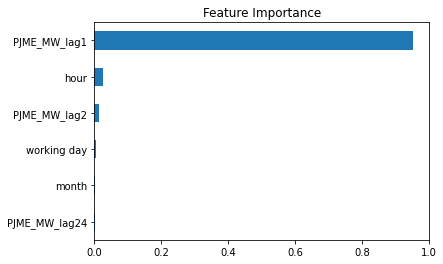

In [30]:
feature_importance = pd.DataFrame(data = best_model.feature_importances_,
             index = X.columns,
             columns = ['importance'])
feature_importance['importance'].sort_values(ascending = False)
feature_importance['importance'].sort_values().plot(kind = 'barh', title = 'Feature Importance');

In [31]:

train_pred = best_model.predict(X)

added_lags_features = added_lags_df.columns.tolist()
test_pred = model_predict(X, y, test_df,
                 time_features_to_add, output_parameter,
                added_lags_features = added_lags_features, 
                added_lags = added_lags, 
                model_input_features = X.columns.tolist(),
                model = best_model)
print('Test error :', root_mean_squared_error(test_df[output_parameter].fillna(method = 'bfill'), test_pred))
print('Train error :', root_mean_squared_error(train_pred, y))

Test error : 3748.945658488779
Train error : 262.71808505368494


#### Actual vs. Predicted: Train data

In [24]:
test_index = test_df.index.tolist()
train_index = X.index.tolist()
labelled_data = pd.DataFrame(columns = ['Actual', 'Predicted'], index = train_index + test_index)
labelled_data.loc[train_index, 'Actual'] = y[output_parameter].values
labelled_data.loc[test_index, 'Actual'] = test_df[output_parameter].values
labelled_data.loc[train_index, 'Predicted'] = train_pred
labelled_data.loc[test_index, 'Predicted'] = test_pred

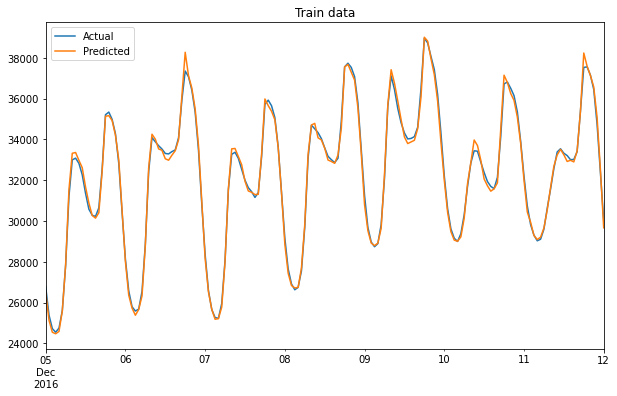

In [25]:
output_processing = TargetVariableProcessing(labelled_data)
start_date = '2016-12-05'
days, title = 7, 'Train data'
output_processing.plotting_timeseries(
                            labelled_data,
                            start_date,
                            end_date = None,
                            days = days, 
                            figsize = (10,6),
                            title = title
                            )

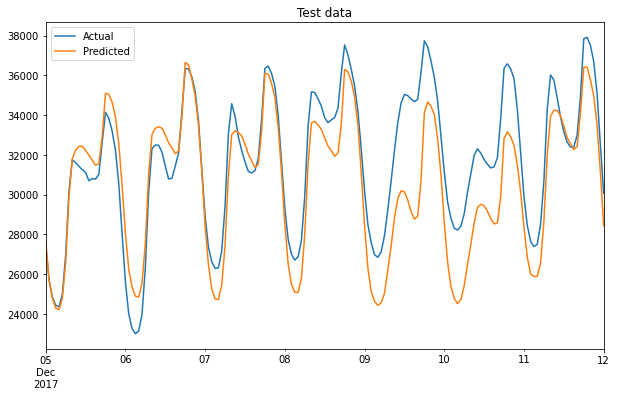

In [32]:
output_processing = TargetVariableProcessing(labelled_data)
start_date = '2017-12-05'
days, title = 7, 'Test data'
output_processing.plotting_timeseries(
                            labelled_data,
                            start_date,
                            end_date = None,
                            days = days, 
                            figsize = (10,6),
                            title = title
                            )

The best fitted model follows both peaks of the day (9 AM and 6 PM), and trough (around 3 AM). 